<h1 style='color: yellow'> Metric Generator </h1>

Generates all the ToE metrics

In [1]:
# Standard Library Imports
import os
import sys
from importlib import reload
from functools import partial
from enum import Enum
from typing import NamedTuple
from time import sleep, time
from glob import glob
from pathlib import Path
# Third-Party Library Imports
import numpy as np
from numpy.typing import ArrayLike
import pandas as pd
import xarray as xr
import dask
from scipy.stats import spearmanr
# Plotting imports
import hvplot.xarray
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import ticker as mticker
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
import seaborn as sns
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

# My imports
sys.path.append(os.path.join(os.getcwd(), 'Documents', 'time_of_emergene_drafts'))
sys.path.append(os.path.join(os.getcwd(), 'Documents', 'time_of_emergene_drafts', 'src'))
import constants
import utils
import plotting_utils
import climate_utils
import my_stats
import diagnostic_tools
import paths

import time_of_emergence_calc as toe_calc
import time_of_emergence_data_analysis as toe_da
import toe_constants as toe_const
import open_data
from toe_constants import PVALUE_THESHOLD1, OVERLAP_THRESHOLD, SN_THRESHOLD1
import time_of_emergence_plots
import toe_constants as toe_const
import plotting_utils
import misc
# Suppress Warnings
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', message="p-value floored: true value smaller than 0.001")
warnings.filterwarnings('ignore', message="p-value capped: true value larger than 0.25")

Matplotlib created a temporary cache directory at /jobfs/132828946.gadi-pbs/matplotlib-nuecdbhx because the default path (/home/563/ab2313/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
Matplotlib is building the font cache; this may take a moment.


In [ ]:
xr.set_options(display_expand_data=False)

In [2]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='numpy.lib.function_base')

In [3]:
# import matplotlib.pylab as pylab
# pylab.rcParams.update({'axes.labelsize':20, 'xtick.labelsize': 16, 'ytick.labelsize': 16, 'figure.figsize': [12, 6]})

In [4]:
# client.close()

In [5]:
from dask.distributed import Client, wait
# # client = Client(threads_per_worker=1, n_workers=20)
# client.close()
client = Client(n_workers=30, threads_per_worker=1, memory_limit=None) 
client

 - State start
 - Found stale lock file and directory '/jobfs/132828946.gadi-pbs/dask-scratch-space/scheduler-w73js_gw', purging
 - Found stale lock file and directory '/jobfs/132828946.gadi-pbs/dask-scratch-space/worker-ygzgipp5', purging
 - Found stale lock file and directory '/jobfs/132828946.gadi-pbs/dask-scratch-space/worker-484b3jen', purging
 - Found stale lock file and directory '/jobfs/132828946.gadi-pbs/dask-scratch-space/worker-9evhluh8', purging
 - Found stale lock file and directory '/jobfs/132828946.gadi-pbs/dask-scratch-space/worker-9tusr6dg', purging
 - Found stale lock file and directory '/jobfs/132828946.gadi-pbs/dask-scratch-space/worker-jhdhm1h1', purging
 - Found stale lock file and directory '/jobfs/132828946.gadi-pbs/dask-scratch-space/worker-ortxu7wa', purging
 - Found stale lock file and directory '/jobfs/132828946.gadi-pbs/dask-scratch-space/worker-1ohkaezd', purging
 - Found stale lock file and directory '/jobfs/132828946.gadi-pbs/dask-scratch-space/worker-gx

<Client: 'tcp://127.0.0.1:36889' processes=30 threads=30>

In [6]:
xr.set_options(display_expand_attrs=False)
xr.set_options(display_expand_data=True)
np.set_printoptions(precision=2, suppress=True, edgeitems=1)

<h1 style='color:yellow'> Opening Data </h1>

In [7]:
print(np.array(toe_const.YearRange))

[<YearRange.MODERN_PERIOD: (1959, 1989)>
 <YearRange.MID_20TH_CENTURY: (1929, 1959)>
 <YearRange.EARLY_20TH_CENTURY: (1899, 1929)>
 <YearRange.ERA5_START: (1940, 1970)>]


In [8]:
# Create a data set for the base period used as the pre-industrial climate 
# base_period = #(1959, 1989)#(1900, 1950)#(1900, 1931)
base_period = toe_const.YearRange.ERA5_START
base_period, base_period.start, base_period.end

(<YearRange.ERA5_START: (1940, 1970)>, 1940, 1970)

In [9]:
dataset_name  =  'era5'
variable = 'sd'
#'gpcc', 'pr'#'era5',  'tx99count' # 'best', 'tas''tx99p9count'

In [10]:
t_start = time()

In [48]:
os.listdir(constants.TOE_SAVE_DIR)

['era5_tp_(1940_1970)',
 'gpcc_pr_(1940_1970)',
 'era5_tx99p99count_(1940_1970)',
 'era5_tx99p9count_(1940_1970)',
 'era5_tx99count_(1940_1970)',
 'old',
 'best_tas_(1940_1970)',
 '.ipynb_checkpoints',
 'era5_2t_(1940_1970)',
 'era5_rx1d_(1940_1970)']

In [49]:
VAR_SAVE_DIR = os.path.join(
    constants.TOE_SAVE_DIR, f'{dataset_name}_{variable}_({base_period.start}_{base_period.end})')
                            
VAR_SAVE_DIR

'/g/data/w40/ab2313/time_of_emergence/toe_metrics/era5_tx99p9count_(1940_1970)'

In [50]:
# os.makedirs(VAR_SAVE_DIR, exist_ok=True)
# I actually do want error if already exists
# os.rmdir(VAR_SAVE_DIR)
os.makedirs(VAR_SAVE_DIR, exist_ok=True)

In [51]:
# chunks_best_small = {'time':-1, 'lat': 180//10, 'lon': 360//10}

CHUNKS_FOR_ERA5 = {
    'time': -1,
    'lat': 721//7,
    'lon':1440//24
}

# chunks_for_gpcc = {
#     'time':-1,
#     'lat': 360//20,
#     'lon': 720//10
# }

In [16]:
chunks = CHUNKS_FOR_ERA5

<h2 style='color:cyan'> Data Functions </h2>

In [17]:
# # data_ds = open_data.open_best(chunks)

# data_ds = open_data.open_gpcc(resample='YE')
# # # Precip variables must have extra selections
# # # data_ds = data_ds.sel(time=data_ds.time.dt.month==12)

In [18]:
# data_ds

In [19]:
# from glob import glob
# var = 'tmax'
# path = f'/g/data/rt52/era5/single-levels/reanalysis/{var}/*/*.nc'
# files_to_open = glob(path, recursive=True)
# print(len(files_to_open))
# td = xr.open_dataset(files_to_open[-30])

In [20]:
# resample = 'QS-JUN'#'QS-DEC' # 'YE'
# chunks = open_data.CHUNKS['access']['small']

# data_ds = open_data.open_access(
#     variable='pr',
#     ensemble='r10i1p1f1',
#     scenario='ssp585',
#     resample=resample
# ).chunk(chunks).isel(time=slice(1, None))

In [21]:
# import paths
# np.array(os.listdir(paths.ERA5_PATH))

In [22]:
# # Potential era5 variables - cape, skt (skin temperature), smlt (snow melt)
# # data_ds = open_data.open_era5('tmax', resample_method='max', save=True).isel(time=slice(None, -1))
# chunks = open_data.ERA5_CHUNKS #ERA5_SMALL_CHUNKS
# data_ds = open_data.open_era5(
#     't2m',
#     return_raw = False,
#     save = True,
#     resample_method = "sum",
#     logginglevel='INFO',
#     chunks = chunks,
# )
# data_ds = data_ds.isel(time=slice(None, -1))
# # data_das = open_data.open_era5_reanalysis('tmax') # Only use this if saving. Otherwise use open_era5

In [23]:
# data_ds

<h2 style='color: cyan'> ERA5 Resample (large data) </h2>

### Processing

In [24]:
# np.array(os.listdir('/g/data/rt52/era5/single-levels'))
# np.array(os.listdir('/g/data/rt52/era5/single-levels/monthly-averaged'))

In [25]:
client.cluster.scale(100)
sleep(6)

 -         Start Nanny at: 'tcp://127.0.0.1:36181'
 -         Start Nanny at: 'tcp://127.0.0.1:34129'
 -         Start Nanny at: 'tcp://127.0.0.1:39977'
 -         Start Nanny at: 'tcp://127.0.0.1:35273'
 -         Start Nanny at: 'tcp://127.0.0.1:32941'
 -         Start Nanny at: 'tcp://127.0.0.1:34745'
 -         Start Nanny at: 'tcp://127.0.0.1:37781'
 -         Start Nanny at: 'tcp://127.0.0.1:44075'
 -         Start Nanny at: 'tcp://127.0.0.1:37631'
 -         Start Nanny at: 'tcp://127.0.0.1:35745'
 -         Start Nanny at: 'tcp://127.0.0.1:42187'
 -         Start Nanny at: 'tcp://127.0.0.1:43693'
 -         Start Nanny at: 'tcp://127.0.0.1:43209'
 -         Start Nanny at: 'tcp://127.0.0.1:43399'
 -         Start Nanny at: 'tcp://127.0.0.1:34333'
 -         Start Nanny at: 'tcp://127.0.0.1:33911'
 -         Start Nanny at: 'tcp://127.0.0.1:41635'
 -         Start Nanny at: 'tcp://127.0.0.1:42143'
 -         Start Nanny at: 'tcp://127.0.0.1:42795'
 -         Start Nanny at: 'tcp

In [65]:
# #'2t': 2m tempeature
# # 'tp': total precipitation
# var = '2t'
# rsn: snow density
# sd: snow depth
variable = 'sd'
original_name = variable#'2t'
base_path = f'/g/data/rt52/era5/single-levels/reanalysis'
path = os.path.join(base_path, original_name)
path

'/g/data/rt52/era5/single-levels/reanalysis/sd'

In [50]:
MY_ERA5_PATH = os.path.join(paths.DATA_DIR, 'era5')
output_file = Path(os.path.join(MY_ERA5_PATH, f"{variable}.zarr"))
output_file

PosixPath('/g/data/w40/ab2313/time_of_emergence/era5/sd.zarr')

In [51]:
wild_tag = '*/*.nc'
years = np.sort(os.listdir(path))
files_to_open = np.array(glob(os.path.join(path, wild_tag), recursive=True))
files_to_open.shape

(1017,)

In [52]:
files_to_open[:2]

array(['/g/data/rt52/era5/single-levels/reanalysis/sd/1945/sd_era5_oper_sfc_19450101-19450131.nc',
       '/g/data/rt52/era5/single-levels/reanalysis/sd/1945/sd_era5_oper_sfc_19451101-19451130.nc'],
      dtype='<U88')

In [56]:
td0 = xr.open_dataset(files_to_open[0])
td = xr.open_dataset(files_to_open[-1])

In [54]:
td[variable].attrs

{'units': 'm of water equivalent',
 'long_name': 'Snow depth',
 'standard_name': 'lwe_thickness_of_surface_snow_amount'}

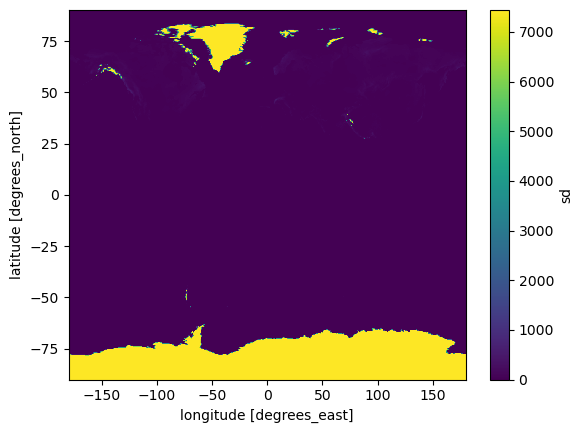

In [58]:
td0.sum(dim='time')[variable].plot()

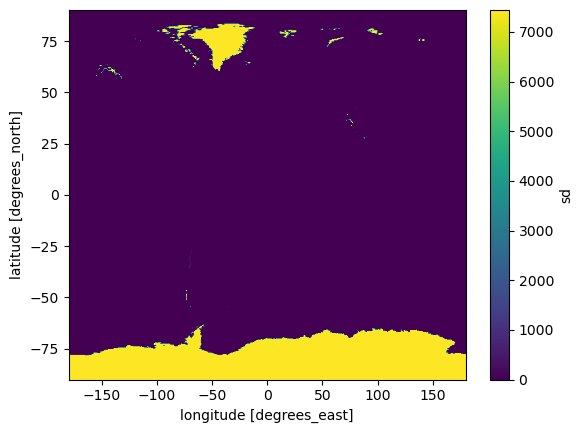

In [59]:
td.sum(dim='time')[variable].plot()

In [38]:
# climatology_files = np.array([
#     f for f in files_to_open 
#     if (
#         (year := int(f.split('/')[-2])) > base_period.start 
#         and year < base_period.end
#     )
# ])

In [39]:
def __preprocess(ds):
    return ds.to_array().rename({'latitude': 'lat', 'longitude': 'lon'})

In [66]:
output_file_tmp = str(output_file).replace('.zarr', '_tmp.zarr')
output_file_tmp

'/g/data/w40/ab2313/time_of_emergence/era5/sd_tmp.zarr'

In [62]:
# clim_list = []
# for i, year in enumerate(np.arange(base_period.start, base_period.end)):
#     print(f'{year}, ', end='')
#     year_file = np.sort([f for f in files_to_open if str(year) in f.split('/')[-2]])
#     da_raw = xr.open_mfdataset(
#         year_file,
#         use_cftime=True,
#         chunks = CHUNKS_FOR_ERA5,
#         preprocess = __preprocess
#     )

#     # Annual averagte tempature
#     da = da_raw.resample(time="1D").mean()
    
#     da = da.squeeze("variable", drop=True)
#     da.name = original_name
#     clim_list.append(da)

In [63]:
# %%time
# base_period_ds = xr.concat(clim_list, dim='time').chunk(CHUNKS_FOR_ERA5)
# base_period_percentile_ds = base_period_ds.reduce(my_stats.dask_percentile, q=99.9, dim='time')
# base_period_percentile_ds = base_period_percentile_ds.persist()
# wait(base_period_percentile_ds)

In [64]:
years_to_use = years #[years.astype(int) > 1981].astype(str)
years_to_use

array(['1940', '1941', '1942', '1943', '1944', '1945', '1946', '1947',
       '1948', '1949', '1950', '1951', '1952', '1953', '1954', '1955',
       '1956', '1957', '1958', '1959', '1960', '1961', '1962', '1963',
       '1964', '1965', '1966', '1967', '1968', '1969', '1970', '1971',
       '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979',
       '1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987',
       '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995',
       '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003',
       '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011',
       '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019',
       '2020', '2021', '2022', '2023', '2024'], dtype='<U4')

In [64]:
for year in years_to_use: #years
    print(f'{year}, ', end='')
    year_file = np.sort([f for f in files_to_open if year in f.split('/')[-2]])
    da_raw = xr.open_mfdataset(
        year_file,
        use_cftime=True,
        chunks = chunks,
        preprocess = __preprocess
    )

    # Annual averagte tempature OR mean snow density
    # da = da_raw.resample(time='Y').mean().compute()

    # Rx1d
    # daily_resample = da_raw.resample(time="1D").sum()
    # da = daily_resample.resample(time="1Y").max()

    # Yearly total preci
    # da = da_raw.resample(time='YE').sum()

    # TX99Count
    # daily_mean_da = da_raw.resample(time="1D").mean() # Daily mean tempeature
    # da = (daily_mean_da > base_period_percentile_ds).resample(time='YE').sum()
    #.groupby("time.year").sum()

    da = da.chunk(chunks)
    da = da.squeeze("variable", drop=True)
    da.name = original_name
    
    # # Save to Zarr
    if year == years[0]:
        # First year: Create the Zarr file
        da.to_zarr(output_file_tmp, mode="w", consolidated=True)
        print(f"Saved {year} to {output_file}")
    else:
        # Subsequent years: Append to the Zarr file
        da.to_zarr(output_file_tmp, mode="a", append_dim="time")
        print(f"Appended {year} to {output_file}")

1982, Appended 1982 to /g/data/w40/ab2313/time_of_emergence/era5/tx99p9count.zarr
1983, Appended 1983 to /g/data/w40/ab2313/time_of_emergence/era5/tx99p9count.zarr
1984, Appended 1984 to /g/data/w40/ab2313/time_of_emergence/era5/tx99p9count.zarr
1985, Appended 1985 to /g/data/w40/ab2313/time_of_emergence/era5/tx99p9count.zarr
1986, Appended 1986 to /g/data/w40/ab2313/time_of_emergence/era5/tx99p9count.zarr
1987, Appended 1987 to /g/data/w40/ab2313/time_of_emergence/era5/tx99p9count.zarr
1988, Appended 1988 to /g/data/w40/ab2313/time_of_emergence/era5/tx99p9count.zarr
1989, Appended 1989 to /g/data/w40/ab2313/time_of_emergence/era5/tx99p9count.zarr
1990, Appended 1990 to /g/data/w40/ab2313/time_of_emergence/era5/tx99p9count.zarr
1991, Appended 1991 to /g/data/w40/ab2313/time_of_emergence/era5/tx99p9count.zarr
1992, Appended 1992 to /g/data/w40/ab2313/time_of_emergence/era5/tx99p9count.zarr
1993, Appended 1993 to /g/data/w40/ab2313/time_of_emergence/era5/tx99p9count.zarr
1994, Appended 1

In [38]:
# da.attrs

In [39]:
# (daily_mean_da > base_period_99p_ds).resample(time='YE').sum().compute().plot()

In [65]:
output_file_tmp

'/g/data/w40/ab2313/time_of_emergence/era5/tx99p9count_tmp.zarr'

In [121]:
# Open all the files in the tmp file
data_ds = (xr.open_zarr(output_file_tmp, use_cftime=True)
           .to_array()
           .compute()
           .chunk(chunks=CHUNKS_FOR_ERA5))

In [122]:
data_ds.time.dt.year

<xarray.DataArray 'year' (time: 85)> Size: 680B
array([1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951,
       1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963,
       1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975,
       1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987,
       1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999,
       2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011,
       2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023,
       2024])
Coordinates:
  * time     (time) object 680B 1940-12-31 00:00:00 ... 2024-12-31 00:00:00

In [123]:
data_ds = data_ds.squeeze('variable', drop=True)
data_ds.name = variable

In [124]:
# data_ds = data_ds * 1000 # For precipitation

In [125]:
# data_ds.isel(time=16).plot(robust=True)

In [126]:
data_ds.attrs = {
    **data_ds.attrs,
    "dataset_name": 'era5',
    'variable': original_name,
    'save_chunks' : CHUNKS_FOR_ERA5,
    'info':("tp (total precipitation) reampled to daily"
            "sum then resample to yearly max")
}

In [127]:
data_ds

<xarray.DataArray 'tx99p9count' (time: 85, lat: 721, lon: 1440)> Size: 706MB
dask.array<getitem, shape=(85, 721, 1440), dtype=float64, chunksize=(85, 103, 60), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 3kB 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * lon      (lon) float32 6kB -180.0 -179.8 -179.5 -179.2 ... 179.2 179.5 179.8
  * time     (time) object 680B 1940-12-31 00:00:00 ... 2024-12-31 00:00:00
Attributes: (4)

In [128]:
data_ds.to_zarr(output_file, mode='w')

### Opening

In [129]:
MY_ERA5_PATH = os.path.join(paths.DATA_DIR, 'era5')
output_file = Path(os.path.join(MY_ERA5_PATH, f"{variable}.zarr"))
output_file

PosixPath('/g/data/w40/ab2313/time_of_emergence/era5/tx99p9count.zarr')

In [166]:
data_ds = xr.open_zarr(str(output_file), chunks=CHUNKS_FOR_ERA5)[variable]#.to_array()

In [167]:
data_ds = data_ds.fillna(0)

In [168]:
data_ds

<xarray.DataArray 'tx99p9count' (time: 85, lat: 721, lon: 1440)> Size: 706MB
dask.array<where, shape=(85, 721, 1440), dtype=float64, chunksize=(85, 103, 60), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 3kB 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * lon      (lon) float32 6kB -180.0 -179.8 -179.5 -179.2 ... 179.2 179.5 179.8
  * time     (time) datetime64[ns] 680B 1940-12-31 1941-12-31 ... 2024-12-31
Attributes: (4)

In [169]:
# data_ds = data_ds.isel(time=slice(None, -1))

<h2 style='color:cyan'> Data Check </h2>

In [170]:
data_ds = data_ds.transpose(..., "time").chunk(chunks).persist()
wait(data_ds)

DoneAndNotDoneFutures(done={<Future: finished, type: numpy.ndarray, key: ('transpose-e810d78864c0a2e2ef5ff68a4fbb2c3f', 5, 13, 0)>, <Future: finished, type: numpy.ndarray, key: ('transpose-e810d78864c0a2e2ef5ff68a4fbb2c3f', 1, 22, 0)>, <Future: finished, type: numpy.ndarray, key: ('transpose-e810d78864c0a2e2ef5ff68a4fbb2c3f', 6, 8, 0)>, <Future: finished, type: numpy.ndarray, key: ('transpose-e810d78864c0a2e2ef5ff68a4fbb2c3f', 0, 2, 0)>, <Future: finished, type: numpy.ndarray, key: ('transpose-e810d78864c0a2e2ef5ff68a4fbb2c3f', 3, 0, 0)>, <Future: finished, type: numpy.ndarray, key: ('transpose-e810d78864c0a2e2ef5ff68a4fbb2c3f', 6, 15, 0)>, <Future: finished, type: numpy.ndarray, key: ('transpose-e810d78864c0a2e2ef5ff68a4fbb2c3f', 0, 1, 0)>, <Future: finished, type: numpy.ndarray, key: ('transpose-e810d78864c0a2e2ef5ff68a4fbb2c3f', 1, 19, 0)>, <Future: finished, type: numpy.ndarray, key: ('transpose-e810d78864c0a2e2ef5ff68a4fbb2c3f', 5, 20, 0)>, <Future: finished, type: numpy.ndarray, 

In [171]:
chunks

{'time': -1, 'lat': 103, 'lon': 60}

In [172]:
# Make sure chunks is 1
assert len(data_ds.chunksizes['time']) == 1

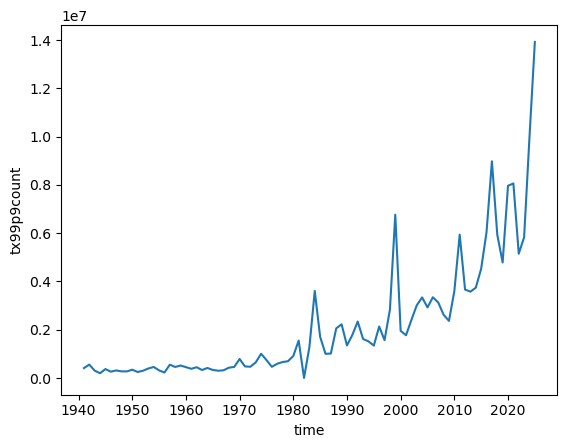

In [173]:
# data_ds.mean(dim=['lat', 'lon']).plot()
data_ds.sum(dim=['lat', 'lon']).plot()

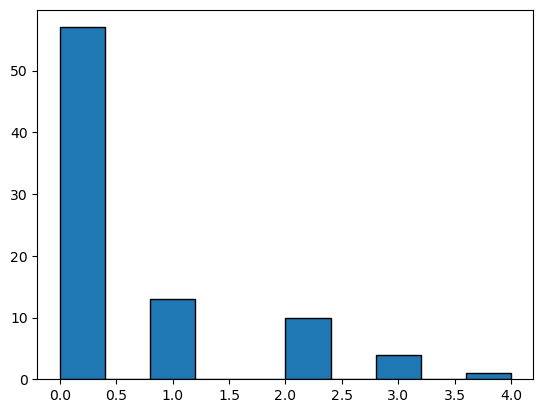

In [174]:
plt.hist(data_ds.sel(lat=-38, lon=145, method='nearest').squeeze().values, edgecolor='k');

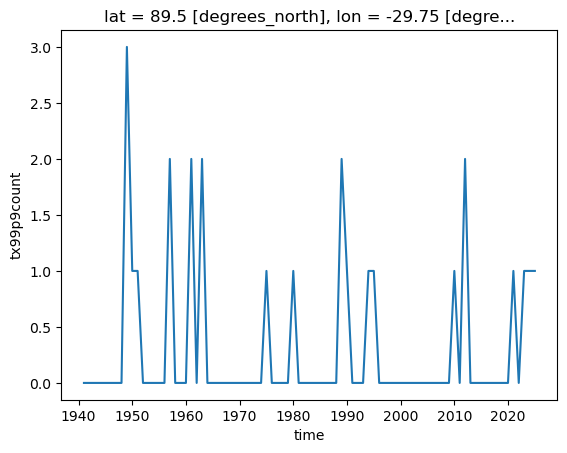

In [175]:
data_ds.sel(lat=89.5, lon=-29.75, method='nearest').plot()

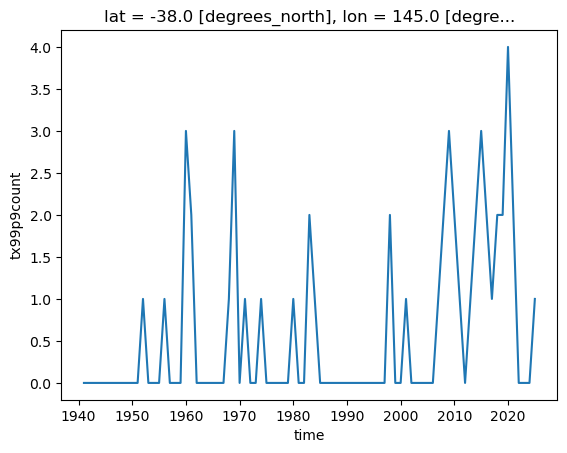

In [176]:
data_ds.sel(lat=-38, lon=145, method='nearest').plot()

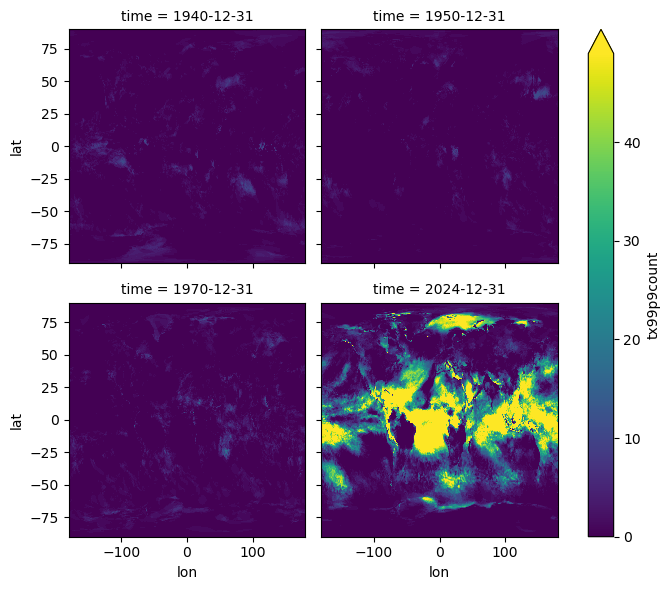

In [177]:
data_ds.isel(time=[0, 10, 30, -1]).plot(col='time', col_wrap=2, robust=True)

In [178]:
# Calculate statistics
min_val = data_ds.min().values.item()
q25_val = data_ds.reduce(np.nanpercentile, q=25).values.item()
q75_val = data_ds.reduce(np.nanpercentile, q=75).values.item()
max_val = data_ds.max().values.item()

# Display nicely
print(f"Statistics:\n"
      f"Min: {min_val:.2f}\n"
      f"25th Percentile: {q25_val:.2f}\n"
      f"75th Percentile: {q75_val:.2f}\n"
      f"Max: {max_val:.2f}")

Statistics:
Min: 0.00
25th Percentile: 0.00
75th Percentile: 1.00
Max: 325.00


In [179]:
len(data_ds.time.values), np.take(data_ds.time.values, [0, 1,2, -3, -2, -1])

(85,
 array(['1940-12-31T00:00:00.000000000', '1941-12-31T00:00:00.000000000',
        '1942-12-31T00:00:00.000000000', '2022-12-31T00:00:00.000000000',
        '2023-12-31T00:00:00.000000000', '2024-12-31T00:00:00.000000000'],
       dtype='datetime64[ns]'))

In [180]:
# Remove data that occurs before this
data_ds = data_ds.sel(time=data_ds.time.dt.year>=base_period.start)
data_ds

<xarray.DataArray 'tx99p9count' (lat: 721, lon: 1440, time: 85)> Size: 706MB
dask.array<getitem, shape=(721, 1440, 85), dtype=float64, chunksize=(103, 60, 85), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 3kB 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * lon      (lon) float32 6kB -180.0 -179.8 -179.5 -179.2 ... 179.2 179.5 179.8
  * time     (time) datetime64[ns] 680B 1940-12-31 1941-12-31 ... 2024-12-31
Attributes: (4)

In [181]:
len(data_ds.time.values), np.take(data_ds.time.values, [0, 1,2, -3, -2, -1])

(85,
 array(['1940-12-31T00:00:00.000000000', '1941-12-31T00:00:00.000000000',
        '1942-12-31T00:00:00.000000000', '2022-12-31T00:00:00.000000000',
        '2023-12-31T00:00:00.000000000', '2024-12-31T00:00:00.000000000'],
       dtype='datetime64[ns]'))

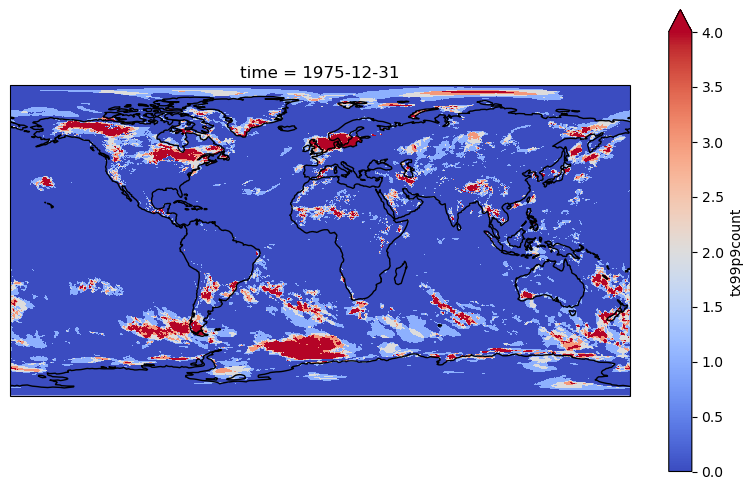

In [182]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
data_ds.isel(time=35).plot(ax=ax,robust=True, cmap='coolwarm')
ax.coastlines()
# ax.set_title('Year 2000')

In [183]:
base_period_ds = data_ds.where(data_ds.time.dt.year.isin(np.arange(*base_period.value)), drop=True)
base_period_ds

<xarray.DataArray 'tx99p9count' (lat: 721, lon: 1440, time: 30)> Size: 249MB
dask.array<where, shape=(721, 1440, 30), dtype=float64, chunksize=(103, 60, 30), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 3kB 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * lon      (lon) float32 6kB -180.0 -179.8 -179.5 -179.2 ... 179.2 179.5 179.8
  * time     (time) datetime64[ns] 240B 1940-12-31 1941-12-31 ... 1969-12-31
Attributes: (4)

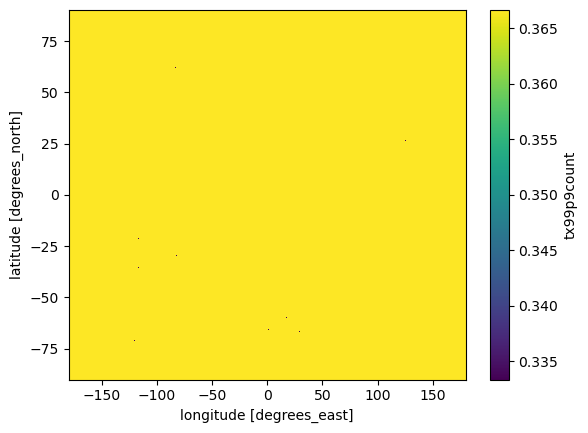

In [184]:
base_period_ds.mean(dim='time').plot()

In [185]:
# Create a mask that removes any grid celss where there are less than 40 point in the base period
base_period_ds_count = base_period_ds.count(dim='time')
# How many years are needed for 80 percent
percent_80_of_years = 0.8*(base_period.end - base_period.start)
data_availability_mask = xr.where(base_period_ds_count>=percent_80_of_years, 1, 0)
data_availability_mask

<xarray.DataArray 'tx99p9count' (lat: 721, lon: 1440)> Size: 8MB
dask.array<where, shape=(721, 1440), dtype=int64, chunksize=(103, 60), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 3kB 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * lon      (lon) float32 6kB -180.0 -179.8 -179.5 -179.2 ... 179.2 179.5 179.8

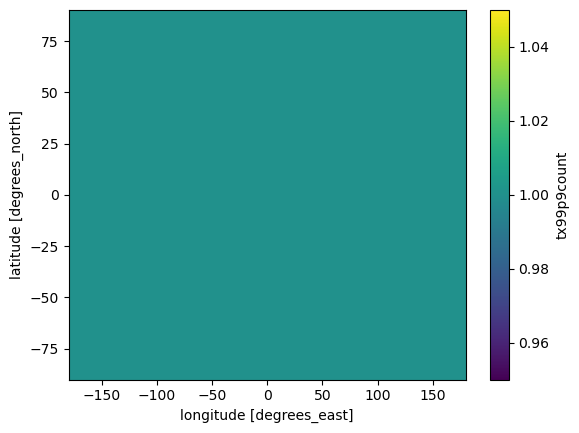

In [186]:
data_availability_mask.plot()

In [187]:
# Apply the mask to both the base period and the full dataset
data_ds = data_ds.where(data_availability_mask)
base_period_ds = base_period_ds.where(data_availability_mask)

In [188]:
# Resetting the anomlies to 1850
data_anom_ds = data_ds - base_period_ds.mean(dim='time')
base_period_anom_ds = base_period_ds - base_period_ds.mean(dim='time')

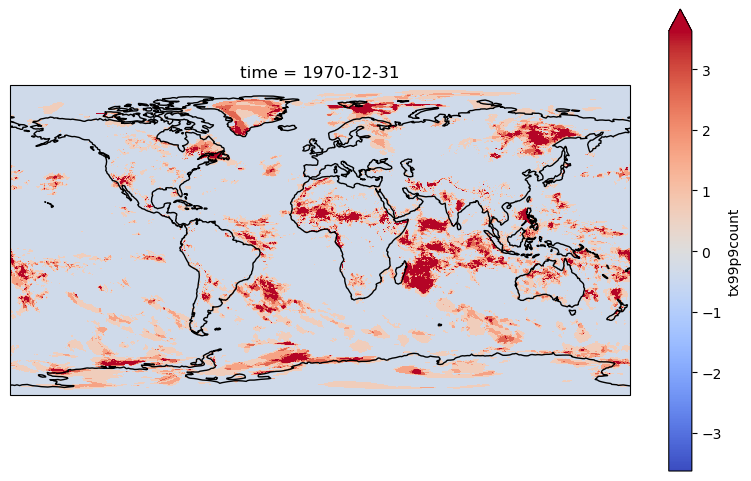

In [189]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
data_anom_ds.isel(time=30).plot(ax=ax,robust=True, cmap='coolwarm')
ax.coastlines()
# ax.set_title('Year 2000')

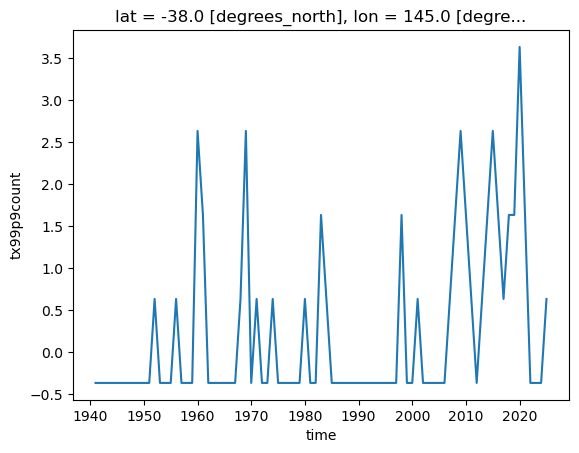

In [190]:
data_anom_ds.sel(lat=-38, lon=145, method='nearest').plot()

In [191]:
data_ds.sel(lat=-38, lon=145, method='nearest').values

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
       0., 0., 3., 2., 0., 0., 0., 0., 0., 0., 1., 3., 0., 1., 0., 0., 1.,
       0., 0., 0., 0., 0., 1., 0., 0., 2., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 2., 0., 0., 1., 0., 0., 0., 0., 0., 1., 2.,
       3., 2., 1., 0., 1., 2., 3., 2., 1., 2., 2., 4., 2., 0., 0., 0., 1.])

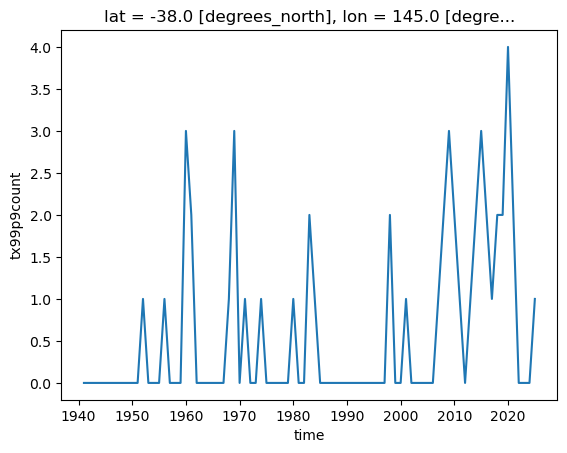

In [192]:
data_ds.sel(lat=-38, lon=145, method='nearest').plot()

<h1 style='color: yellow'> Metric Calculation </h1>

<h2 style='color: cyan'>Dataset set-up </h2>

<ul>
    <li> Scaling client</li>
    <li> Chunking data set</li>
</ul>

In [193]:
window = 30

In [194]:
CHUNKS_FOR_PVALUE_TESTS = chunks

In [195]:
data_ds_window = (data_ds
                  .rolling(time=window, center=True, min_periods=window)
                  .construct('window_dim')
                  .chunk({'window_dim':-1,**CHUNKS_FOR_PVALUE_TESTS})
                  .persist()
                 ) 

base_period_window_ds = (base_period_ds
                         .chunk(CHUNKS_FOR_PVALUE_TESTS)
                         .rename({'time':'window_dim'})
                         .persist()
                        )

In [196]:
wait(data_ds_window);
wait(base_period_window_ds);

In [197]:
data_ds_window

<xarray.DataArray 'tx99p9count' (lat: 721, lon: 1440, time: 85, window_dim: 30)> Size: 21GB
dask.array<rechunk-merge, shape=(721, 1440, 85, 30), dtype=float64, chunksize=(103, 60, 85, 30), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 3kB 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * lon      (lon) float32 6kB -180.0 -179.8 -179.5 -179.2 ... 179.2 179.5 179.8
  * time     (time) datetime64[ns] 680B 1940-12-31 1941-12-31 ... 2024-12-31
Dimensions without coordinates: window_dim
Attributes: (4)

In [198]:
data_ds_window.chunks

((103, 103, 103, 103, 103, 103, 103),
 (60,
  60,
  60,
  60,
  60,
  60,
  60,
  60,
  60,
  60,
  60,
  60,
  60,
  60,
  60,
  60,
  60,
  60,
  60,
  60,
  60,
  60,
  60,
  60),
 (85,),
 (30,))

In [199]:
base_period_window_ds

<xarray.DataArray 'tx99p9count' (lat: 721, lon: 1440, window_dim: 30)> Size: 249MB
dask.array<where, shape=(721, 1440, 30), dtype=float64, chunksize=(103, 60, 30), chunktype=numpy.ndarray>
Coordinates:
  * lat         (lat) float32 3kB 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * lon         (lon) float32 6kB -180.0 -179.8 -179.5 ... 179.2 179.5 179.8
  * window_dim  (window_dim) datetime64[ns] 240B 1940-12-31 ... 1969-12-31
Attributes: (4)

In [200]:
# The arguements needed for all of the calculations
rolling_window_kwargs = dict(
    input_core_dims=[['window_dim'], ['window_dim']],
    exclude_dims={'window_dim'},
    vectorize=True,
    dask='parallelized')

In [201]:
# # P-value methods works better with a large cluster.
# # Small chunks with large computation
client.cluster.scale(200);
sleep(7);

 -         Start Nanny at: 'tcp://127.0.0.1:35111'
 -         Start Nanny at: 'tcp://127.0.0.1:38117'
 -         Start Nanny at: 'tcp://127.0.0.1:37739'
 -         Start Nanny at: 'tcp://127.0.0.1:39499'
 -         Start Nanny at: 'tcp://127.0.0.1:41917'
 -         Start Nanny at: 'tcp://127.0.0.1:45609'
 -         Start Nanny at: 'tcp://127.0.0.1:45267'
 -         Start Nanny at: 'tcp://127.0.0.1:35045'
 -         Start Nanny at: 'tcp://127.0.0.1:39449'
 -         Start Nanny at: 'tcp://127.0.0.1:38073'
 -         Start Nanny at: 'tcp://127.0.0.1:38041'
 -         Start Nanny at: 'tcp://127.0.0.1:39193'
 -         Start Nanny at: 'tcp://127.0.0.1:33683'
 -         Start Nanny at: 'tcp://127.0.0.1:34755'
 -         Start Nanny at: 'tcp://127.0.0.1:44409'
 -         Start Nanny at: 'tcp://127.0.0.1:33011'
 -         Start Nanny at: 'tcp://127.0.0.1:45801'
 -         Start Nanny at: 'tcp://127.0.0.1:39307'
 -         Start Nanny at: 'tcp://127.0.0.1:36513'
 -         Start Nanny at: 'tcp

<h2 style='color: cyan'> Overlap Methods - Optimized</h2>

In [203]:
kde_kwargs= dict(bw_method=0.2) # silverman, scott#bw_method=0.2)

### Perkins

In [204]:
data_arr = data_ds.values.flatten()
# #data_arr = data_arr[data_arr != 0]

In [205]:
bins = toe_calc.calculate_freedman_diaconis_bins(data_arr, length=len(data_ds.time.values),
                                                logginglevel='DEBUG')

np.unique(np.diff(bins).round(6)).item(), bins

p75=1.0, p25=0.0, iqr=1.0, length=85
 - 0.45487320390519065


(0.454873,
 array([ -0.45,   0.  ,   0.45,   0.91,   1.36,   1.82,   2.27,   2.73,
          3.18,   3.64,   4.09,   4.55,   5.  ,   5.46,   5.91,   6.37,
          6.82,   7.28,   7.73,   8.19,   8.64,   9.1 ,   9.55,  10.01,
         10.46,  10.92,  11.37,  11.83,  12.28,  12.74,  13.19,  13.65,
         14.1 ,  14.56,  15.01,  15.47,  15.92,  16.38,  16.83,  17.29,
         17.74,  18.19,  18.65,  19.1 ,  19.56,  20.01,  20.47,  20.92,
         21.38,  21.83,  22.29,  22.74,  23.2 ,  23.65,  24.11,  24.56,
         25.02,  25.47,  25.93,  26.38,  26.84,  27.29,  27.75,  28.2 ,
         28.66,  29.11,  29.57,  30.02,  30.48,  30.93,  31.39,  31.84,
         32.3 ,  32.75,  33.21,  33.66,  34.12,  34.57,  35.03,  35.48,
         35.93,  36.39,  36.84,  37.3 ,  37.75,  38.21,  38.66,  39.12,
         39.57,  40.03,  40.48,  40.94,  41.39,  41.85,  42.3 ,  42.76,
         43.21,  43.67,  44.12,  44.58,  45.03,  45.49,  45.94,  46.4 ,
         46.85,  47.31,  47.76,  48.22,  48.67,  49.1

In [206]:
np.min(bins), np.max(bins)

(-0.45487320390519065, 325.2343407922113)

In [208]:
data_ds.min().values.item(), data_ds.max().values.item()

(0.0, 325.0)

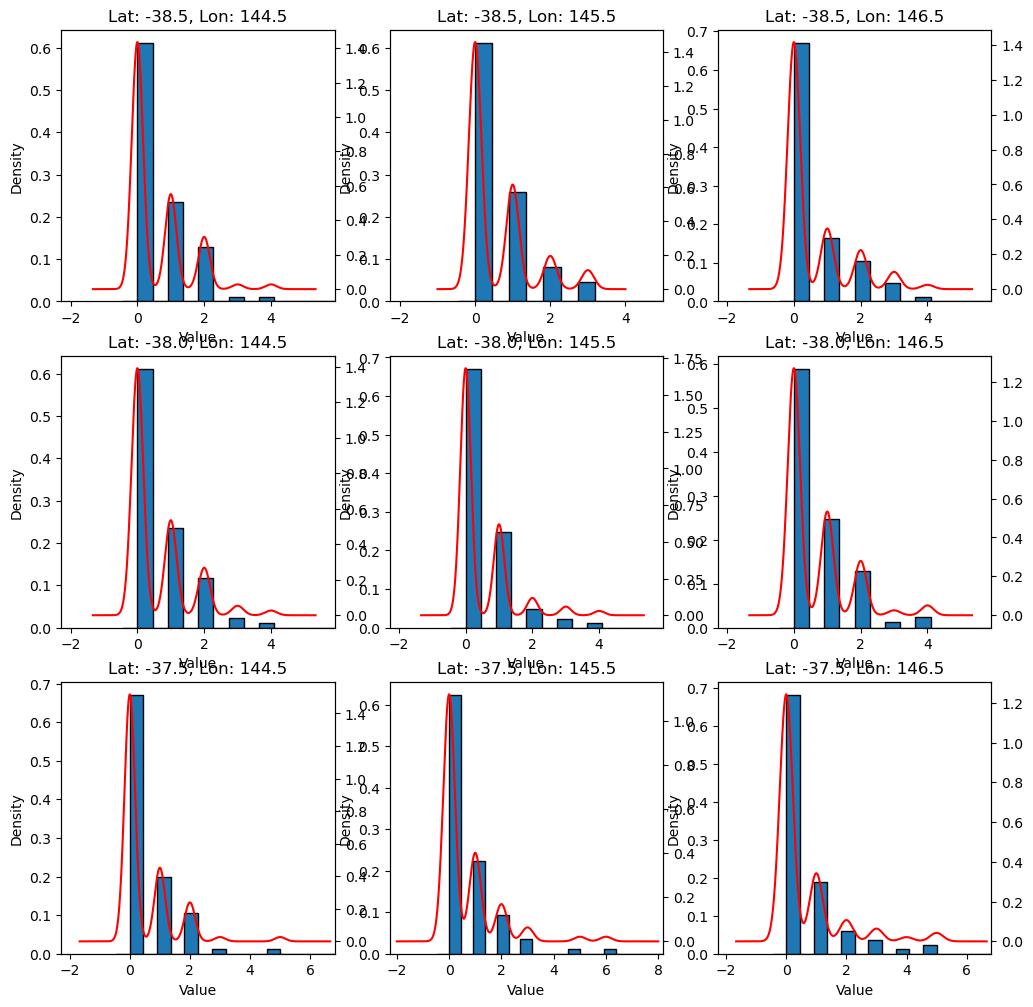

In [209]:
# Example latitudes and longitudes range (adjust as needed)
lats = np.linspace(-38.5, -37.5, 3)  # Replace with your actual latitudes
lons = np.linspace(144.5, 146.5, 3)  # Replace with your actual longitudes

# Create a 3x3 plot grid
fig, axs = plt.subplots(3, 3, figsize=(12, 12))

# Loop through latitudes and longitudes
for i, lat in enumerate(lats):
    for j, lon in enumerate(lons):
        # Extract the data for the current lat, lon
        test_data = data_ds.sel(lat=lat, lon=lon, method='nearest').values
        
        # Compute the KDE
        _, rel_freq = toe_calc.discrete_pdf(test_data, bins=bins)
        x_test, kde_test = toe_calc.create_kde(test_data, **kde_kwargs)

        # Plot on the current subplot
        ax = axs[i, j]
        ax2 = ax.twinx()
        ax.bar(bins[:-1], rel_freq, width=np.diff(bins), align='edge', edgecolor='k')
        ax2.plot(x_test, kde_test, color='r')
        ax.set_title(f'Lat: {lat}, Lon: {lon}')
        ax.set_xlabel('Value')
        ax.set_ylabel('Density')
        valid_bins = bins[:-1][rel_freq > 0]
        x_min, x_max = valid_bins.min()-5*np.diff(bins)[0], valid_bins.max()+5*np.diff(bins)[0]
        ax.set_xlim(x_min, x_max)

In [210]:
%%time
# Pre-calculate the relative frequency of the base period

base_period_rel_freq_ds = xr.apply_ufunc(
    toe_calc.get_rel_freq,
    base_period_ds,
    input_core_dims=[['time']],
    output_core_dims=[['bins']],
    kwargs={'bins': bins},
    vectorize=True,
    dask='parallelized',
    output_sizes={'bins': len(bins) - 1}, 
    output_dtypes=float
).persist()
wait(base_period_rel_freq_ds)

CPU times: user 4.02 s, sys: 3.11 s, total: 7.13 s
Wall time: 7.35 s


DoneAndNotDoneFutures(done={<Future: finished, type: numpy.ndarray, key: ('transpose-eefd167f306f48f1cea16dc9efd1befb', 1, 6, 0)>, <Future: finished, type: numpy.ndarray, key: ('transpose-eefd167f306f48f1cea16dc9efd1befb', 6, 11, 0)>, <Future: finished, type: numpy.ndarray, key: ('transpose-eefd167f306f48f1cea16dc9efd1befb', 5, 18, 0)>, <Future: finished, type: numpy.ndarray, key: ('transpose-eefd167f306f48f1cea16dc9efd1befb', 0, 2, 0)>, <Future: finished, type: numpy.ndarray, key: ('transpose-eefd167f306f48f1cea16dc9efd1befb', 3, 1, 0)>, <Future: finished, type: numpy.ndarray, key: ('transpose-eefd167f306f48f1cea16dc9efd1befb', 4, 1, 0)>, <Future: finished, type: numpy.ndarray, key: ('transpose-eefd167f306f48f1cea16dc9efd1befb', 0, 4, 0)>, <Future: finished, type: numpy.ndarray, key: ('transpose-eefd167f306f48f1cea16dc9efd1befb', 4, 22, 0)>, <Future: finished, type: numpy.ndarray, key: ('transpose-eefd167f306f48f1cea16dc9efd1befb', 5, 20, 0)>, <Future: finished, type: numpy.ndarray, k

In [211]:
%%time
perkins_ds = xr.apply_ufunc(
    toe_calc.perkins_skill_score_base_bins,
    data_ds_window,
    base_period_rel_freq_ds,
    kwargs={'bins': bins},
    input_core_dims=[['window_dim'], ['bins']],
    exclude_dims={'window_dim'},
    vectorize=True,
    dask='parallelized',
    output_dtypes=float
    ).compute()

CPU times: user 24.4 s, sys: 18.5 s, total: 42.9 s
Wall time: 55.5 s


In [212]:
perkins_ds = perkins_ds.sortby('lat')

In [213]:
perkins_ds.attrs = {
    'window': window,
    **perkins_ds.attrs,
    'bins': 
    {
        'start':bins.round(4)[0],
        'stop':bins.round(4)[-1],
        'step': np.unique(np.diff(bins)).round(4)[0]}
}

In [214]:
location = dict(lat=69, lon=-165, method='nearest')

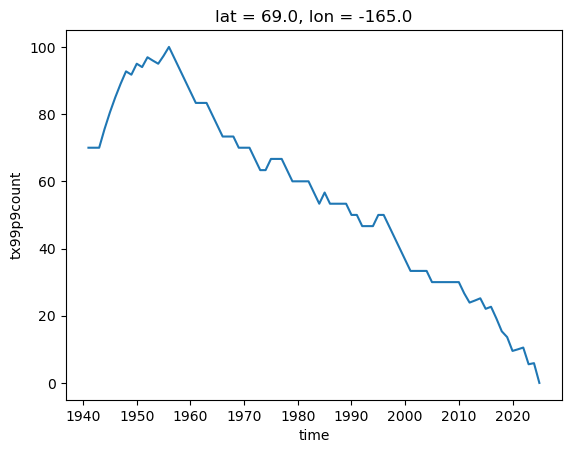

In [215]:
perkins_ds.sel(**location).plot()

In [216]:
base_arr = base_period_ds.sel(**location).values
rel_freq_base = toe_calc.rel_freq(base_arr, bins)
future_arr = data_ds.sel(**location).where(
    data_ds.time.dt.year.isin(np.arange(base_period.start, base_period.start+window)), drop=True).values
rel_freq_future = toe_calc.rel_freq(future_arr, bins=bins)

In [218]:
toe_calc.discrete_distribution_overlap(rel_freq_base, rel_freq_future),\
toe_calc.perkins_skill_score(future_arr, base_arr, bins=bins),\
perkins_ds.sel(**location).isel(time=int(window/2)).values.item()

(100.0, 100.0, 100.0)

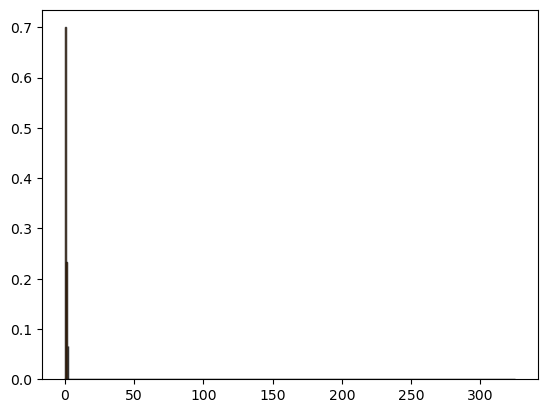

In [219]:
fig, ax = plt.subplots(1, 1)
diagnostic_tools.plot_bar(bins, rel_freq_base, ax=ax)
diagnostic_tools.plot_bar(bins, rel_freq_future, ax=ax)

In [220]:
toe_calc.perkins_skill_score_base_bins(
    data_ds_window.sel(lat=-39, lon=145,method='nearest').isel(time=slice(None, 30)).values,
    base_period_rel_freq_ds.sel(lat=-39, lon=145,method='nearest').values,
    bins=bins
)

98.58974358974358

<BarContainer object of 716 artists>

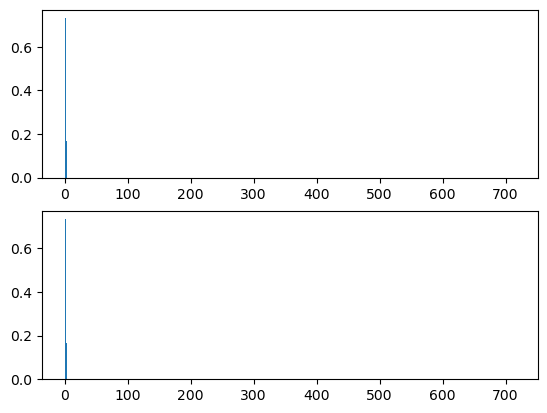

In [221]:
fig, (ax1, ax2) = plt.subplots(2, 1)

test_loc = dict(lat=-39, lon=145, method='nearest')
rel_freq_test = toe_calc.get_rel_freq(base_period_ds.sel(**test_loc).squeeze().values, bins=bins)

ax1.bar(base_period_rel_freq_ds.bins.values, rel_freq_test)
ax2.bar(base_period_rel_freq_ds.bins.values, base_period_rel_freq_ds.sel(**test_loc).values)

 - colorbar update normal <matplotlib.colors.Normalize object at 0x15322d344850> <matplotlib.colors.Normalize object at 0x15322d344850>
 - locator: <matplotlib.ticker.AutoLocator object at 0x15322d35b4c0>
 - colorbar update normal <matplotlib.colors.Normalize object at 0x15322d344850> <matplotlib.colors.Normalize object at 0x15322d344850>
 - locator: <matplotlib.ticker.AutoLocator object at 0x15322d35b4c0>
 - locator: <matplotlib.ticker.AutoLocator object at 0x15322d35b160>


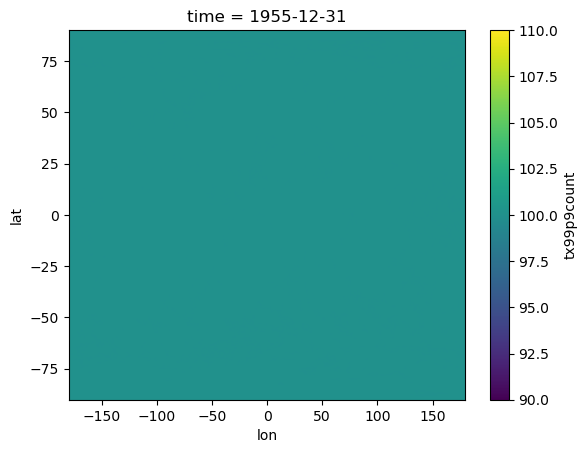

In [227]:
perkins_ds.isel(time=int(window/2)).plot();

 - locator: <matplotlib.ticker.FixedLocator object at 0x15322f6d66e0>


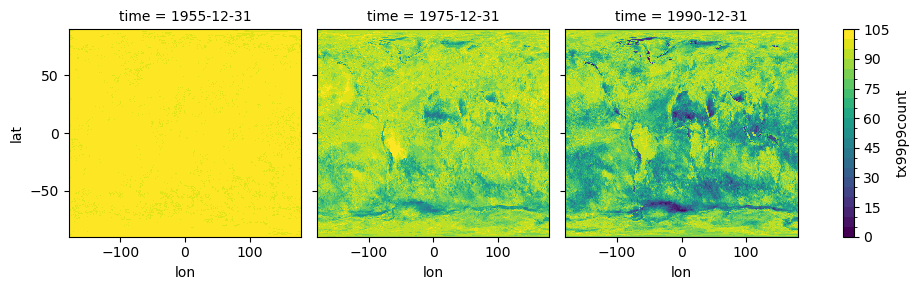

In [229]:
perkins_ds.isel(time=[int(window/2), 35, 50]).plot(col='time', levels=np.arange(0, 110, 5))

### KDE Metrics

In [230]:
def create_kde_x_exists(arr: np.ndarray, x: np.ndarray, **kwargs):
    """
    Create a KDE for the given array and evaluate it at the specified points.

    Parameters:
    - arr: np.ndarray, input data for KDE computation.
    - x: np.ndarray, points at which to evaluate the KDE.
    - kwargs: Additional arguments to pass to scipy.stats.gaussian_kde.

    Returns:
    - kde_vals: np.ndarray, normalized KDE values evaluated at `x`.
    """
    if np.all(np.isnan(arr)): return np.tile(np.nan, len(x))
    
    # Remove NaN and infinite values from the array
    arr = arr[np.isfinite(arr)]

    if np.ptp(arr) <= 0.1: # The values differ by less than 0.1
        # Jitter the values by an amount of 10^-6
        arr = arr + np.random.normal(0, 1e-6, size=arr.shape)
    
    # Compute the KDE
    try:
        kde = toe_calc.gaussian_kde(arr, **kwargs)
    except np.linalg.LinAlgError as e:
        return np.tile(np.nan, len(x))
    kde_vals = kde(x)

    # Normalize the KDE values to ensure total area equals 1
    kde_vals /= np.trapz(kde_vals, x)

    return kde_vals


In [231]:
def calculate_kde_overlap(dist1, dist2, x):
    """
    Calculate the percentage overlap between two probability density functions (KDEs).
    
    Parameters:
    - dist1: array-like, first KDE values evaluated on x.
    - dist2: array-like, second KDE values evaluated on x.
    - x: array-like, the points where dist1 and dist2 are evaluated.
    
    Returns:
    - overlap_percent: float, percentage overlap between the two distributions.
    """
    # Calculate the overlap shape by taking the minimum of the two KDEs at each point
    overlap_shape = np.minimum(dist1, dist2)
    
    # Integrate the overlap shape to find the overlap area
    overlap_area = np.trapz(overlap_shape, x)
    
    # Convert the overlap area to a percentage (assuming KDEs are normalized)
    overlap_percent = overlap_area * 100

    return overlap_percent


In [232]:
def __overlap_helper_function_base_fitted(
    arr_future: np.ndarray, kde_base: np.ndarray,
    overlap_function, x, method_kwargs=None) -> float:
    """
    Helper function to calculate the overlap between the KDEs of two arrays using a specified overlap function.

    Parameters:
    arr_future (numpy.ndarray): First input array of values.
    arr_base (numpy.ndarray): Second input array of values.
    return_all (bool): If False (default) just return the overlap percent. If True,
                        return the KDEs and the overlap percent.
    kde_kwargs (dict, optional): Keyword arguments to pass to the KDE creation function.
    bmax (float, optional): Maximum value for the range of the KDE.
    bmin (float, optional): Minimum value for the range of the KDE.
    overlap_function (callable, optional): Function to calculate overlap between two distributions.
                                           Should accept `kde_base`, `kde_future`, and `x` as arguments.

    Returns:
    float: Overlap area as calculated by the specified overlap function. Returns NaN if any array is fully NaN.
    """
    if not method_kwargs: method_kwargs = {}

    # Check if any input array is fully NaN
    if np.all(np.isnan(arr_future)) or np.all(np.isnan(kde_base)): return np.nan

    kde_future = create_kde_x_exists(arr_future, x, **method_kwargs)
    
    out_metric = overlap_function(kde_base, kde_future, x)
    return out_metric

In [233]:
fractional_geometric_area_optimized = partial(
    __overlap_helper_function_base_fitted,
    overlap_function=calculate_kde_overlap)

In [234]:
hellinger_distance_optimized = partial(
    __overlap_helper_function_base_fitted,
    overlap_function=toe_calc.calculate_hellinger_distance)

In [235]:
# The x-values for the KDE are based upon the max and min
data_max = data_ds.max().persist().values.item()
data_min = data_ds.min().persist().values.item()
num_points = 1000
x = toe_calc.create_x(bmin=data_min, bmax=data_max, num_points=num_points)

data_min, data_max, x.shape

(0.0, 325.0, (1000,))

In [236]:
%%time
# Pre-calculate the base period KDE

base_period_kde = xr.apply_ufunc(
    create_kde_x_exists,
    base_period_ds,
    input_core_dims=[['time'], ],
    output_core_dims=[['x']],
    kwargs={'x': x, **kde_kwargs},
    vectorize=True,
    dask='parallelized',
    output_sizes={'x':len(x)},  # Specify the size of the 'bin' dimension
    output_dtypes=float
).persist()
wait(base_period_kde);

CPU times: user 5.92 s, sys: 4.68 s, total: 10.6 s
Wall time: 11.8 s


In [237]:
# # latlon_dict = dict(lat=-38, lon=145, method='nearest')
# # latlon_dict = dict(lat=-38, lon=145, method='nearest')
latlon_dict = dict(lat=-89.5, lon=-29.75, method='nearest')
hellinger_distance_optimized(
    arr_future=data_ds_window.sel(**latlon_dict).isel(time=slice(30, 60)).values,
    kde_base = base_period_kde.sel(**latlon_dict).values,
    x=x
)

38.30884516013569

In [238]:
%%time
hellinger_ds = xr.apply_ufunc(
    hellinger_distance_optimized,
    data_ds_window,
    base_period_kde,
    input_core_dims=[['window_dim'], ['x']],
    exclude_dims={'window_dim'},
    kwargs={'x': x, 'method_kwargs':kde_kwargs},
    vectorize=True,
    dask='parallelized',
    output_dtypes=float
).compute()

/jobfs/132828946.gadi-pbs/ipykernel_1707600/426398749.py:30: RuntimeWarning: invalid value encountered in divide
/jobfs/132828946.gadi-pbs/ipykernel_1707600/426398749.py:30: RuntimeWarning: invalid value encountered in divide
/jobfs/132828946.gadi-pbs/ipykernel_1707600/426398749.py:30: RuntimeWarning: invalid value encountered in divide
/jobfs/132828946.gadi-pbs/ipykernel_1707600/426398749.py:30: RuntimeWarning: invalid value encountered in divide
/jobfs/132828946.gadi-pbs/ipykernel_1707600/426398749.py:30: RuntimeWarning: invalid value encountered in divide
/jobfs/132828946.gadi-pbs/ipykernel_1707600/426398749.py:30: RuntimeWarning: invalid value encountered in divide
/jobfs/132828946.gadi-pbs/ipykernel_1707600/426398749.py:30: RuntimeWarning: invalid value encountered in divide
/jobfs/132828946.gadi-pbs/ipykernel_1707600/426398749.py:30: RuntimeWarning: invalid value encountered in divide
/jobfs/132828946.gadi-pbs/ipykernel_1707600/426398749.py:30: RuntimeWarning: invalid value encou

CPU times: user 2min 28s, sys: 2min 13s, total: 4min 42s
Wall time: 8min 41s


In [239]:
%%time
frac_geom_ds = xr.apply_ufunc(
    fractional_geometric_area_optimized,
    data_ds_window,
    base_period_kde,
    input_core_dims=[['window_dim'], ['x']],
    exclude_dims={'window_dim'},
    kwargs={'x': x, 'method_kwargs':kde_kwargs},
    vectorize=True,
    dask='parallelized',
    output_dtypes=float
).compute()
# wait(frac_geom_ds2)

/jobfs/132828946.gadi-pbs/ipykernel_1707600/426398749.py:30: RuntimeWarning: invalid value encountered in divide
/jobfs/132828946.gadi-pbs/ipykernel_1707600/426398749.py:30: RuntimeWarning: invalid value encountered in divide
/jobfs/132828946.gadi-pbs/ipykernel_1707600/426398749.py:30: RuntimeWarning: invalid value encountered in divide
/jobfs/132828946.gadi-pbs/ipykernel_1707600/426398749.py:30: RuntimeWarning: invalid value encountered in divide
/jobfs/132828946.gadi-pbs/ipykernel_1707600/426398749.py:30: RuntimeWarning: invalid value encountered in divide
/jobfs/132828946.gadi-pbs/ipykernel_1707600/426398749.py:30: RuntimeWarning: invalid value encountered in divide
/jobfs/132828946.gadi-pbs/ipykernel_1707600/426398749.py:30: RuntimeWarning: invalid value encountered in divide
/jobfs/132828946.gadi-pbs/ipykernel_1707600/426398749.py:30: RuntimeWarning: invalid value encountered in divide
/jobfs/132828946.gadi-pbs/ipykernel_1707600/426398749.py:30: RuntimeWarning: invalid value encou

CPU times: user 1min 52s, sys: 1min 52s, total: 3min 44s
Wall time: 7min 48s


In [240]:
x_attrs = { 'bmin': data_min, 'bmax':data_max, 'num_points': num_points}
frac_geom_ds.attrs = {'window': window,**frac_geom_ds.attrs, **kde_kwargs, **x_attrs}
hellinger_ds.attrs =  {'window': window, **hellinger_ds.attrs, **kde_kwargs, **x_attrs}

In [241]:
hellinger_ds.attrs

{'window': 30,
 'bw_method': 0.2,
 'bmin': 0.0,
 'bmax': 325.0,
 'num_points': 1000}

In [ ]:
hellinger_ds.isel(time=[10, 35, 50]).plot(col='time', levels=np.arange(0, 110, 10))

 - locator: <matplotlib.ticker.FixedLocator object at 0x15323e28ad70>


In [ ]:
frac_geom_ds.isel(time=[10, 35, 50]).plot(col='time', levels=np.arange(0, 110, 10))

In [ ]:
frac_geom_ds.isel(time=window//2).plot();

In [ ]:
hellinger_ds.isel(time=window//2).plot();

In [ ]:
fig, ax1 = plt.subplots(1, 1)

test_loc = dict(lat=-39, lon=145, method='nearest')

test_kde = create_kde_x_exists(base_period_ds.sel(**test_loc).values, x, **kde_kwargs)

ax1.plot(x, base_period_kde.sel(**test_loc).values)
ax1.plot(x, test_kde, linestyle='--')

### Old - Ufunc

In [ ]:
# %%time
# perkins_ds = xr.apply_ufunc(
#     toe_calc.perkins_skill_score,
#     data_ds_window,
#     base_period_window_ds,
#     kwargs={'bins': bins},
#     output_dtypes=float,
#     **rolling_window_kwargs
#     ).compute().sortby('lat')

In [ ]:
# %%time
# frac_geom_ds = xr.apply_ufunc(
#     toe_calc.fractional_geometric_area,
#     data_ds_window,
#     base_period_window_ds,
#     kwargs = dict(method_kwargs=kde_kwargs),
#     output_dtypes=float,
#     **rolling_window_kwargs
#     ).compute()

In [ ]:
# %%time
# hellinger_ds = xr.apply_ufunc(
#     toe_calc.hellinger_distance,
#     data_ds_window,
#     base_period_window_ds,
#     kwargs = dict(method_kwargs=kde_kwargs),
#     output_dtypes=float,
#     **rolling_window_kwargs
#     ).compute()

<h2 style='color: cyan'> P-value Methods </h2>

1d Array Method <br>

This method comapes starting from the begging and looops through. The nans are added to the end so the length matches

In [ ]:
# The arguements needed for all of the calculations
rolling_window_kwargs = dict(
    input_core_dims=[['window_dim'], ['window_dim']],
    exclude_dims={'window_dim'},
    vectorize=True,
    dask='parallelized')

In [ ]:
%%time
# Expected: 9 minutes 30 seconds
ttest_ds = xr.apply_ufunc(
        toe_calc.return_ttest_pvalue,
        data_ds_window,
        base_period_window_ds,
    **rolling_window_kwargs
    ).compute()

In [289]:
ttest_ds

<xarray.DataArray 'ttest' (lat: 721, lon: 1440, time: 85)> Size: 706MB
array([[[0.7 , ..., 0.97],
        ...,
        [0.7 , ..., 0.97]],

       ...,

       [[0.9 , ..., 0.  ],
        ...,
        [0.9 , ..., 0.  ]]])
Coordinates:
  * lat      (lat) float32 3kB 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * lon      (lon) float32 6kB -180.0 -179.8 -179.5 -179.2 ... 179.2 179.5 179.8
  * time     (time) datetime64[ns] 680B 1940-12-31 1941-12-31 ... 2024-12-31
Attributes: (1)

In [ ]:
%%time
# Expected 3 minutes 30 seconds - best
# 6 23 - era5
ks_ds = xr.apply_ufunc(
        toe_calc.return_ks_pvalue,
        data_ds_window,
        base_period_window_ds,
    **rolling_window_kwargs
    ).compute()

In [290]:
ks_ds

<xarray.DataArray 'ks' (lat: 721, lon: 1440, time: 85)> Size: 706MB
array([[[1. , ..., 1. ],
        ...,
        [1. , ..., 1. ]],

       ...,

       [[1. , ..., 0.1],
        ...,
        [1. , ..., 0.1]]])
Coordinates:
  * lat      (lat) float32 3kB 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * lon      (lon) float32 6kB -180.0 -179.8 -179.5 -179.2 ... 179.2 179.5 179.8
  * time     (time) datetime64[ns] 680B 1940-12-31 1941-12-31 ... 2024-12-31
Attributes: (1)

In [ ]:
# ks_2samp will perfom on all nan slices
# ks_ds = ks_ds.where(data_availability_mask)

In [ ]:
# %%time
# anderson_ds = xr.apply_ufunc(
#     toe_calc.return_anderson_pvalue,
#     data_ds_window,
#     base_period_window_ds,
#     output_dtypes=float, 
#     **rolling_window_kwargs
#     ).compute()

### Verification of p-value test
- Comparison with 1d rolling func
Verifyting the abstracted (but faster) methods works by comparing to a single lat, lon point.

In [291]:
lat_lon_sp = dict(lat=-34, lon=145, method='nearest')

In [292]:
stats_test_1d_array_ks = partial(
    toe_calc.stats_test_1d_array, stats_func=toe_calc.return_ks_pvalue,
    window=window, base_period_length = base_period.end-base_period.start)

In [293]:
ks_1d_1p = stats_test_1d_array_ks(data_ds.sel(**lat_lon_sp).values)

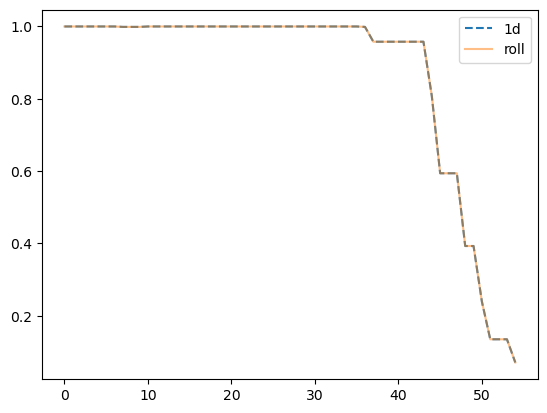

In [294]:
plt.plot(ks_1d_1p,label='1d', linestyle='--')
plt.plot(ks_ds.sel(**lat_lon_sp).isel(time=slice(int(window/2), -int(window/2))).values, label='roll', alpha=0.5)
plt.legend()

<h2 style='color: cyan'> Signal-to-Noise </h2>

<b> Hawkins S/N Ratio</b>

In [ ]:
# Calculate the wegithed mean
data_ds_smean = climate_utils.weighted_lat_lon_mean(data_anom_ds).compute()

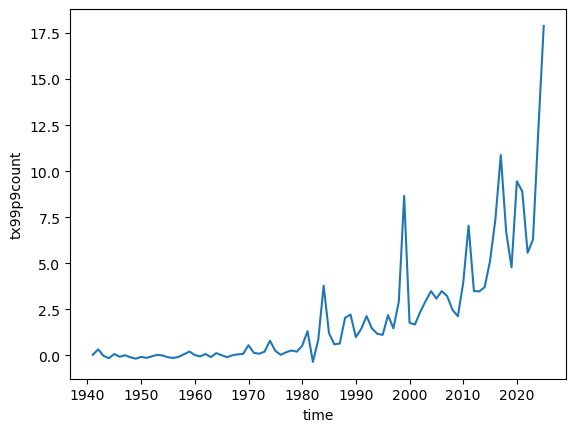

In [295]:
data_ds_smean.plot()

In [ ]:
# Get lowess filtered version
ds_smean_lowess = my_stats.trend_fit(data_ds_smean, method='LOWESS', lowess_window=41)

In [ ]:
%%time
return_hawkins_signal_and_noise_partial = partial(toe_calc.return_hawkins_signal_and_noise, 
                                                  gt=ds_smean_lowess.values)

ds_signal_hawkins, ds_noise_series_hawkins = xr.apply_ufunc(
    return_hawkins_signal_and_noise_partial,
    data_anom_ds,
    input_core_dims=[['time']], 
    output_core_dims=[['time'], ['time']], 
    dask='parallelized', 
    vectorize=True,
    output_dtypes=[float, float],
)

ds_signal_hawkins = ds_signal_hawkins.compute()
ds_noise_series_hawkins = ds_noise_series_hawkins.compute()

In [ ]:
# Noise 
ds_noise_hawkins_full = ds_noise_series_hawkins.std(dim='time').compute()

ds_noise_hawkins_base_period = ds_noise_series_hawkins.where(
    ds_noise_series_hawkins.time.dt.year.isin(np.arange(*base_period.value)), drop=True).std(dim='time')

# S/N Ratio 
ds_sn_hawkins_full = ds_signal_hawkins/ds_noise_hawkins_full
ds_sn_hawkins_base_period = ds_signal_hawkins/ds_noise_hawkins_base_period

<b> Lowess S/N </b>

In [ ]:
ds_signal_lowess = xr.apply_ufunc(
    my_stats.apply_lowess, 
    data_anom_ds.chunk({'time':-1, 'lat':10}), 
    input_core_dims=[['time']],
    output_core_dims=[['time']],
    vectorize=True, 
    dask='parallelized',    
).compute()

In [ ]:
# Noise series is detrended data
ds_noise_series_lowess = (data_anom_ds - ds_signal_lowess).compute()
# Noise is std of detrended data
ds_noise_lowess_full = ds_noise_series_lowess.std(dim='time')

ds_noise_lowess_base_period = ds_noise_series_lowess.where(
    ds_noise_series_lowess.time.dt.year.isin(np.arange(*base_period.value)), drop=True).std(dim='time')

# S/N Ratio
ds_sn_lowess_full = ds_signal_lowess/ds_noise_lowess_full
ds_sn_lowess_base_period = ds_signal_lowess/ds_noise_lowess_base_period

### Plot Verificaiton

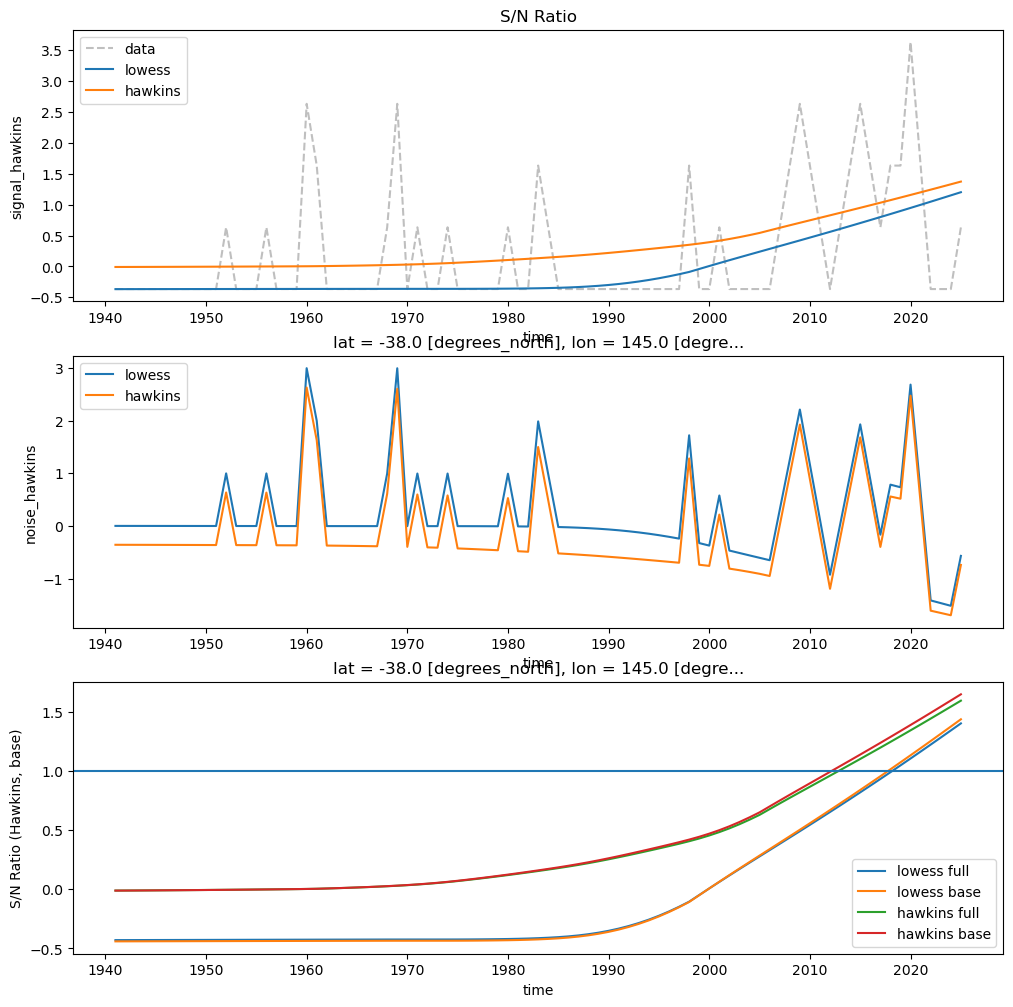

In [296]:
lat_lon_sp = dict(lat=-38, lon=145, method='nearest')

fig, axes = plt.subplots(3, 1, figsize=(12, 12))

ax1 = axes[0]
data_anom_ds.sel(**lat_lon_sp).plot(label='data', ax=ax1, color='grey', linestyle='--', alpha=0.5)
ds_signal_lowess.sel(**lat_lon_sp).plot(label='lowess', ax=ax1)
ds_signal_hawkins.sel(**lat_lon_sp).plot(label='hawkins', ax=ax1)
ax1.set_title('Signal')
ax1.legend()

ax2= axes[1]
ds_noise_series_lowess.sel(**lat_lon_sp).plot(label='lowess', ax=ax2)
ds_noise_series_hawkins.sel(**lat_lon_sp).plot(label='hawkins', ax=ax2)
ax1.set_title('Noise Series')

ax2.legend()

ax3= axes[2]
ds_sn_lowess_full.sel(**lat_lon_sp).plot(label='lowess full', ax=ax3)
ds_sn_lowess_base_period.sel(**lat_lon_sp).plot(label='lowess base', ax=ax3)

ds_sn_hawkins_full.sel(**lat_lon_sp).plot(label='hawkins full', ax=ax3)
ds_sn_hawkins_base_period.sel(**lat_lon_sp).plot(label='hawkins base', ax=ax3)
ax1.set_title('S/N Ratio')
ax3.axhline(1)
ax3.legend()

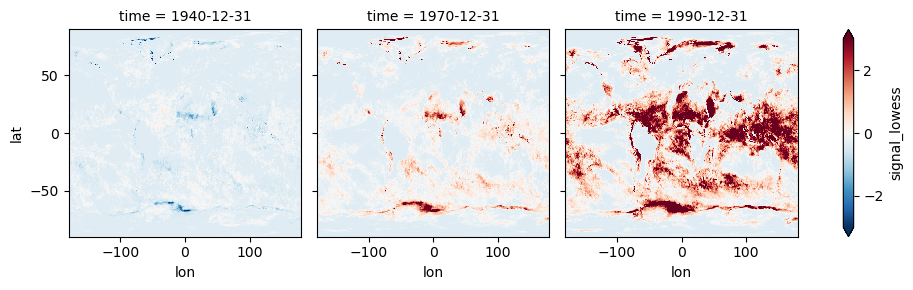

In [297]:
ds_signal_lowess.isel(time=[0, 30, 50]).plot(col='time', robust=True)

In [ ]:
# Rolling noise variant
# ds_data_noise_lowess_rolling = ds_data_noise_series_lowess.rolling(time=window, min_periods=2).std(dim='time').compute()
# First time step is nan, so remove
# ds_data_noise_lowess_rolling = ds_data_noise_lowess_rolling.isel(time=slice(1, None))
# This is odd. But I am making the fire 19 years (wnindow lenght) have the same noise as the first time the 
# variability can be calculated.
# ds_data_noise_lowess_rolling = xr.concat([
#     ds_data_noise_lowess_rolling.isel(time=slice(0, window-2)).fillna(ds_data_noise_lowess_rolling.isel(time=window-1)),
#     ds_data_noise_lowess_rolling.isel(time=slice(window-1, None))], dim='time')
# ds_data_noise_lowess_rolling = misc.adjust_time_from_rolling(ds_data_noise_lowess_rolling, window)

In [ ]:
# ds_data_noise_lowess_rolling.sel(lat=-40, lon=144, method='nearest')

In [ ]:
# ds_data_sn_lowess_rolling = ds_data_signal_lowess/ds_data_noise_lowess_rolling
# # First time step is nan for noise, so remove
# ds_data_sn_lowess_rolling = ds_data_sn_lowess_rolling.isel(time=slice(1, None))

In [ ]:
# ds_data_noise_lowess_rolling.sel(lat=-38, lon=145, method='nearest').plot()

In [ ]:
# ds_data_sn_lowess

In [ ]:
# client.cluster.scale(6)
# sleep(7)

<h1 style='color: yellow'>  Data Mering and Save </h1>

In [ ]:
ds_signal_lowess.name = 'signal_lowess'
ds_noise_series_lowess.name = 'noise_lowess'
ds_signal_hawkins.name = 'signal_hawkins'
ds_noise_series_hawkins.name = 'noise_hawkins'

In [ ]:
ds_sn_hawkins_full.name = 'sn_hawkins_full'
ds_sn_hawkins_base_period.name = 'sn_hawkins_base'
ds_sn_lowess_full.name = 'sn_lowess_full'
ds_sn_lowess_base_period.name = 'sn_lowess_base'

ks_ds.name = 'ks'
ttest_ds.name = 'ttest'
perkins_ds.name = 'perkins'
frac_geom_ds.name = 'frac'
hellinger_ds.name = 'hd'

In [ ]:
# Set long name attributes for each variable
ds_sn_hawkins_full.attrs['long_name'] = 'S/N Ratio (Hawkins, full)'
ds_sn_hawkins_base_period.attrs['long_name'] = 'S/N Ratio (Hawkins, base)'

ds_sn_lowess_full.attrs['long_name'] = 'S/N Ratio (LOWESS, full)'
ds_sn_lowess_base_period.attrs['long_name'] = 'S/N Ratio (LOWESS, base)'

ttest_ds.attrs['long_name'] = 'T-Test'
ks_ds.attrs['long_name'] = 'Kolmogorov-Smirnov'
perkins_ds.attrs['long_name'] = 'Perkins Skill Score'
frac_geom_ds.attrs['long_name'] = 'Fractional Geometric Area'
hellinger_ds.attrs['long_name'] = 'Hellinger Distance'

In [ ]:
toe_metrics_ds = xr.merge([ks_ds, ttest_ds, perkins_ds, frac_geom_ds, hellinger_ds,
                           ds_sn_hawkins_full,ds_sn_hawkins_base_period,
                          ds_sn_lowess_full, ds_sn_lowess_base_period])

toe_metrics_ds = toe_metrics_ds.isel(time=slice(int(window/2), -int(window/2)))
toe_metrics_ds = toe_metrics_ds.compute()
toe_metrics_ds

In [ ]:
dataset_name, variable, base_period

In [ ]:
VAR_SAVE_DIR

In [ ]:
# There is also a lot of processing that has been udnergone for this dataset.
# Worth saving just to keep complete consistency
DATA_SAVE_NAME = os.path.join(VAR_SAVE_DIR, f'data.zarr')
print(DATA_SAVE_NAME)
data_anom_ds.to_zarr(DATA_SAVE_NAME, mode='w')

In [ ]:
# THe signal is actually needed for lots of plots
singal_ds = xr.merge([
    ds_signal_lowess,ds_noise_series_lowess ,ds_signal_hawkins , ds_noise_series_hawkins]) 
singal_ds

In [ ]:
SIGNAL_SAVE_NAME = os.path.join(VAR_SAVE_DIR, f'signal.zarr')
print(SIGNAL_SAVE_NAME)
singal_ds.to_zarr(SIGNAL_SAVE_NAME, mode='w')

In [ ]:
TOE_METRICS_SAVE_NAME = os.path.join(VAR_SAVE_DIR, 'toe_metrics.zarr')
print(TOE_METRICS_SAVE_NAME)
toe_metrics_ds.to_zarr(TOE_METRICS_SAVE_NAME, mode='w')

In [ ]:
data_availability_mask

In [ ]:
DATA_AVAILABILITY_SAVE_NAME = os.path.join(VAR_SAVE_DIR, 'data_availability_mask.zarr')
print(DATA_AVAILABILITY_SAVE_NAME)
data_availability_mask.to_zarr(DATA_AVAILABILITY_SAVE_NAME, mode='w')

In [ ]:
t_end = time()
time_taken = (t_end - t_start)/60
print(f'{time_taken=}minutes')